# Classification d'images avec *tf.keras*

Dans ce projet, on va implémenter des réseaux neuronaux en utilisant les API de Keras.
Nous utiliserons l'implémentation de Keras contenu dans TensorFlow, *tf.keras*.

Lien vers la documentation de [keras.io](https://keras.io/).

Tout le code que nous écrirons dans ce notebook fonctionnera avec la librairie Keras. Nous n'utiliserons pas de lignes spécifiques à TensorFlow.

Pour rappel : la seule différence entre la librairie Keras et le Keras inclus dans TensorFlow est la façon d'importer Keras :

```python
# keras.io code:
from keras.layers import Dense
output_layer = Dense(10)

# corresponding tf.keras code:
from tensorflow.keras.layers import Dense
output_layer = Dense(10)

# or:
from tensorflow import keras
output_layer = keras.layers.Dense(10)
```

#◢  Import & Vérification des versions des librairies

In [2]:
%matplotlib inline
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [7]:
%pip install tensorflow
import tensorflow as tf
from tensorflow import keras  # tf.keras
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


In [8]:
print("python", sys.version)
for module in tf, keras, pd, np, mpl:
    print(module.__name__, module.__version__)

python 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
tensorflow 2.11.0
keras.api._v2.keras 2.11.0
pandas 1.4.4
numpy 1.21.5
matplotlib 3.5.2


In [9]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

#◢  Chargement du jeu de données MNIST

Keras permet de charger de nombreux datasets avec `keras.datasets`.
Nous utiliserons le jeu de données MNIST *Modifier ou Mixed National Institute of Standards and Technology*, qui est une base de données de chiffres manuscrits.


La base MNIST est devenu un test standard. Elle regroupe 60000 images d'apprentissage et 10000 images de test, issues d'une base de données antérieure, appelée simplement NIST1. 
Ces images sont en noir et blanc, normalisées centrées et de 28 pixels de côté.

Pour l’historique de la création de cette base, voir [Yann LeCun](http://yann.lecun.com/exdb/mnist/).

Séparez le jeu de données d'entrainement en :
- un jeu de validation contenant 5000 images
- un jeu d'entrainement contenant 55000 images

In [10]:
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

11490434/11490434 [==============================] - 1s 0us/step


#◢  Exploration des données

Nous avons désormais 3 jeux de données :
- Le jeu de données d'entrainement qui contient 55000 images de tailles 28x28 pixels
- Le jeu de données de validation qui contient 5000 images de tailles 28x28 pixels
- Le jeu de données de test qui contient 10000 images de tailles 28x28 pixels

In [11]:
#Affichage de la taille du X_train
X_train.shape

(55000, 28, 28)

In [12]:
#Affichage de la taille du X_valid
X_valid.shape

(5000, 28, 28)

In [13]:
#Affichage de la taille du X_test
X_test.shape

(10000, 28, 28)

Chaque pixel a une valeur comprise entre 0 et 255

In [14]:
X_train[0][10:15]

array([[  0,   0, 226, 254, 208, 199, 199, 199, 199, 139,  61,  61,  61,
         61,  61, 128, 222, 254, 254, 189,  21,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,  38,  82,  13,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  34, 213, 254, 254, 115,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  84, 254, 254, 234,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  84, 254, 254, 234,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 106, 157, 254, 254, 243,  51,   0,   0,   0,   0,
          0,   0]], dtype=uint8)

Nous pouvons afficher une image en utilisant la fonction de Matplotlib `imshow()`, avec la carte des couleurs `'binary'` :

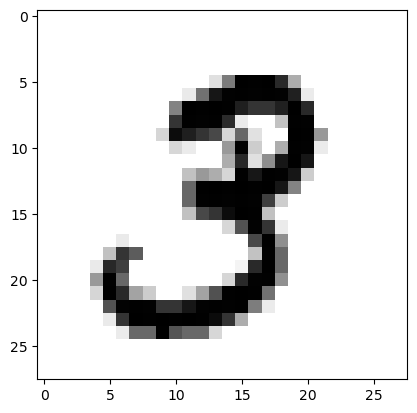

In [15]:
plt.imshow(X_train[1], cmap="binary")
plt.show()

Les labels sont des classes allant de 0 à 9

In [16]:
y_train[:10]

array([7, 3, 4, 6, 1, 8, 1, 0, 9, 8], dtype=uint8)

Regardons quelques images du jeu de données :

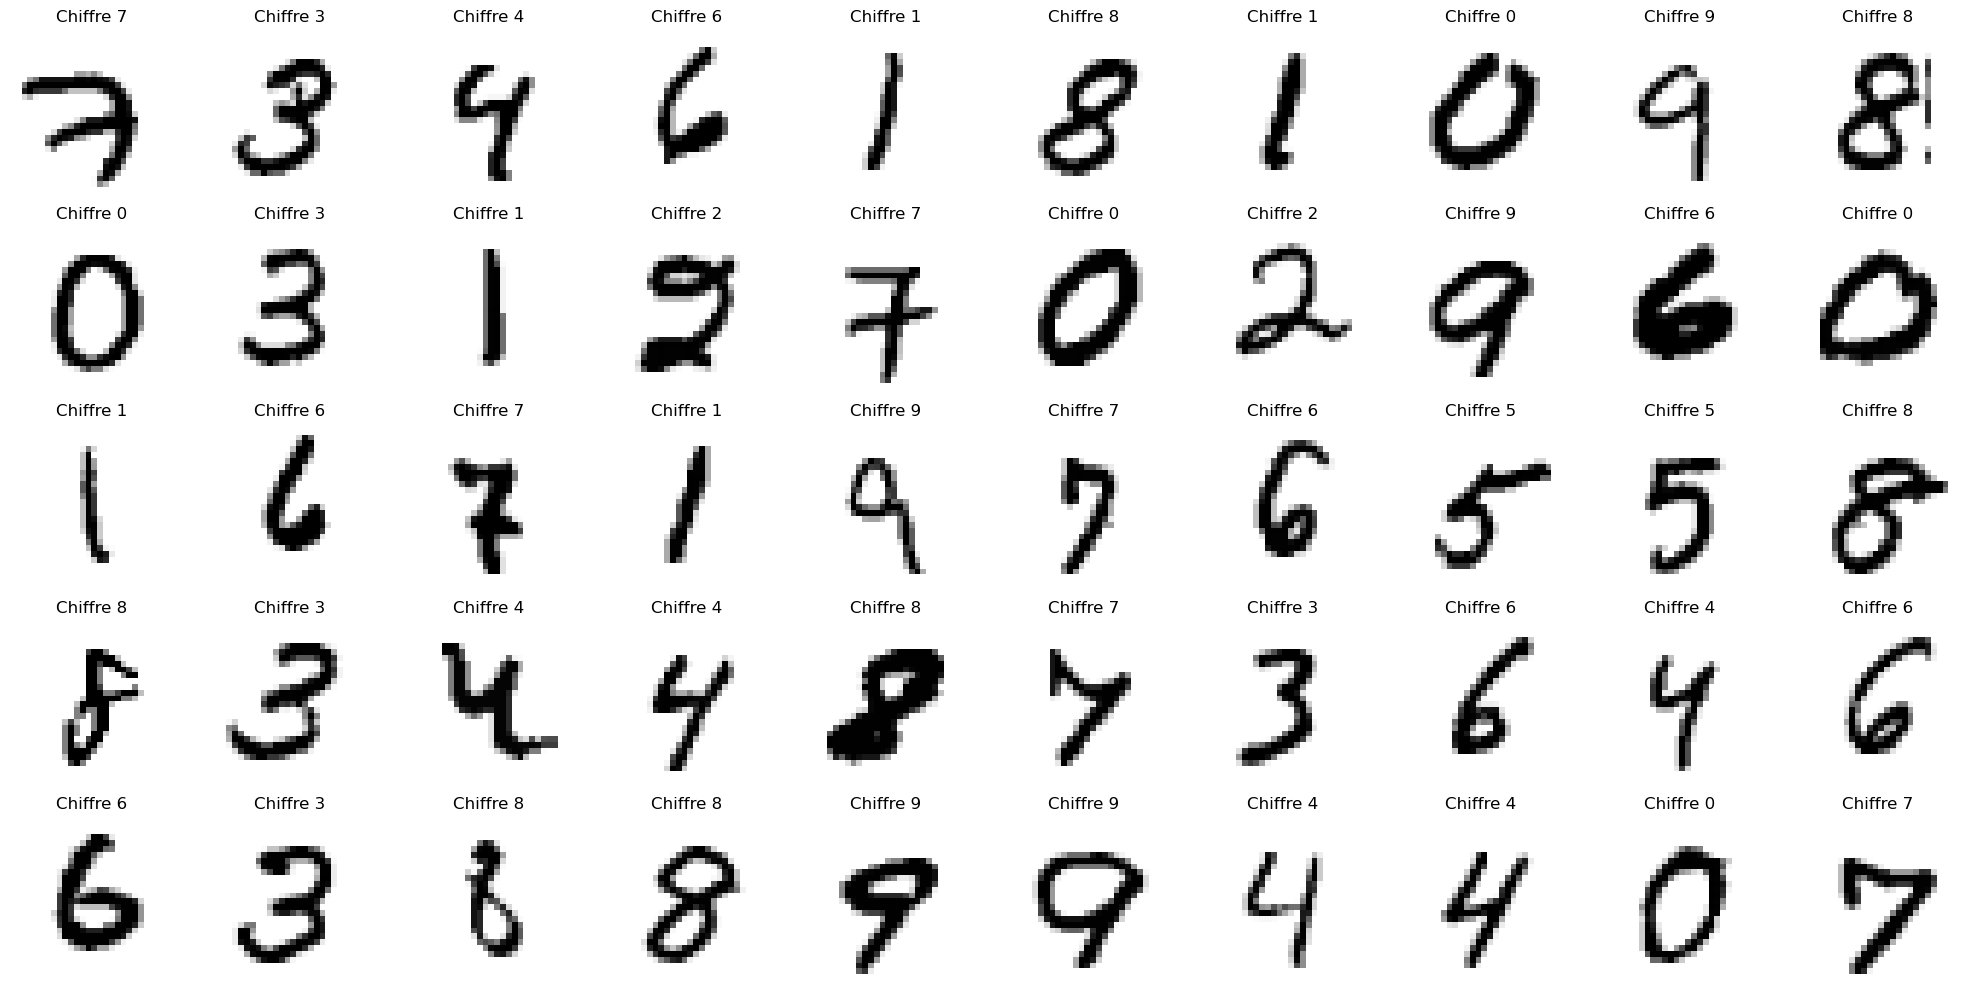

In [17]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*2, n_rows*2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title('Chiffre ' + str(y_train[index]))
plt.tight_layout()
plt.show()

#◢  Pré-Processing
Les images étant dans l'échelle [grayscale](https://en.wikipedia.org/wiki/Grayscale), les valeurs varient de 0 à 255.

Afin de normaliser (centrer) les données, nous allons implémnter la fonction Min-Max scaling dans la fonction `normalize_grayscale()`. Après la mise à l'échelle, les valeurs des pixels des données d'entrée iront de 0.1 à 0.9.

Min-Max Scaling:
$
X'=a+{\frac {\left(X-X_{\min }\right)\left(b-a\right)}{X_{\max }-X_{\min }}}
$







In [18]:
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    #Implementation of Min-Max scaling for grayscale image data :

    a = 0.1
    b = 0.9
    image_data_min = image_data.min()
    image_data_max = image_data.max()
    return a + ((image_data - image_data_min)*(b-a))/(image_data_max - image_data_min)

# Test Cases
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 255])),
    [0.1, 0.103137254902, 0.106274509804, 0.109411764706, 0.112549019608, 0.11568627451, 0.118823529412, 0.121960784314,
     0.125098039216, 0.128235294118, 0.13137254902, 0.9],
    decimal=3)
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 10, 20, 30, 40, 233, 244, 254,255])),
    [0.1, 0.103137254902, 0.13137254902, 0.162745098039, 0.194117647059, 0.225490196078, 0.830980392157, 0.865490196078,
     0.896862745098, 0.9])


train_features = normalize_grayscale(X_train)
val_features = normalize_grayscale(X_valid)
test_features = normalize_grayscale(X_test)

print('Tests Passed!')

Tests Passed!


#◢  Construction d'un modèle 

Construction d'un modèle `Sequential` avec l'API `keras.models.Sequential`, sans aucun argument, et avec 3 couches en utilisant la méthode `add()` :
  * Une couche `Flatten` (`keras.layers.Flatten`) pour convertir chaque image de taille 28x28 image en un simple tableau de 784 pixels. Comme cette couche est la première de votre modèle, vous devez spécifier l'argument `input_shape`.
  * Une couche `Dense` (`keras.layers.Dense`) avec 50 neurones (également appelés units), et la fonction d'activation `"relu"`.
  * Pour finir une couche `Dense` avec 10 neurones (1 par classe), et avec la fonction d'activation `"softmax"` activation pour s'assurer que la somme de toutes les probabilités des classe estimées pour chaque image est égale à 1.

In [19]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

Affichons la liste des couches : 

In [20]:
model.layers

Faisons un `summary` du modèle :

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________


#◢  Compilation du modèle

Nous utiliserons : 
La fonction de cout `"sparse_categorical_crossentropy"`, l'optimiseur suivant `keras.optimizers.SGD(lr=0.01)`(stochastic gradient descent avec un learning rate à 0.01) et la métrique : `metrics=["accuracy"]`. 

**Note**: Dans la documenation de Keras, vous trouverez d'autres fontions de cout `keras.losses`, d'autres métriques `keras.metrics` et d'autres optimiseurs `keras.optimizer`.

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.SGD(lr=0.01),
             metrics=["accuracy"])

#◢  Entrainement du modèle

Définissons :
- le nombre d'epochs `epochs=5`
- les données de validation `validation_data=(val_features, y_valid)`

**Note**: La méthode `fit()` retourne un objet `History` qui contient les statistiques d'entrainement. N'oubliez pas de récupérer cet objet (`history = model.fit(...)`).

In [23]:
history = model.fit(train_features, y_train, epochs=5,
                    validation_data=(val_features, y_valid))

Epoch 1/5
1719/1719 [==============================] - 3s 1ms/step - loss: 0.8322 - accuracy: 0.7848 - val_loss: 0.4291 - val_accuracy: 0.8874
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3954 - accuracy: 0.8909 - val_loss: 0.3358 - val_accuracy: 0.9040
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3368 - accuracy: 0.9043 - val_loss: 0.2979 - val_accuracy: 0.9178
Epoch 4/5
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3070 - accuracy: 0.9123 - val_loss: 0.2754 - val_accuracy: 0.9220
Epoch 5/5
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2861 - accuracy: 0.9189 - val_loss: 0.2577 - val_accuracy: 0.9266


Regardons les valeurs de la fonction de cout et de l'accuracy sur les 2 jeux de données (train et validation)

In [24]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

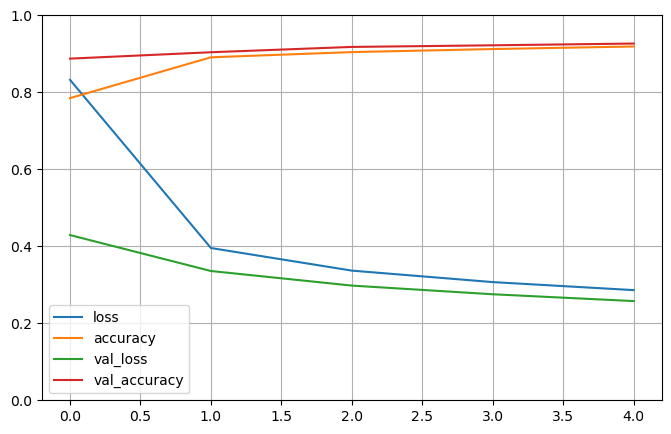

In [25]:
plot_learning_curves(history)

Relancez `model.fit()` avec 3 epochs, que se passe-t-il ?

In [26]:
history = model.fit(train_features, y_train, epochs=3,
                    validation_data=(val_features, y_valid))

Epoch 1/3
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2699 - accuracy: 0.9237 - val_loss: 0.2452 - val_accuracy: 0.9310
Epoch 2/3
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2561 - accuracy: 0.9270 - val_loss: 0.2351 - val_accuracy: 0.9354
Epoch 3/3
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2446 - accuracy: 0.9307 - val_loss: 0.2234 - val_accuracy: 0.9366


#◢  Evaluation du modèle


In [27]:
model.evaluate(test_features, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.2357 - accuracy: 0.9321


[0.2357167750597, 0.9320999979972839]

#◢  Prédiction


In [28]:
y_proba = model.predict(test_features)
y_proba[:10].round(3)

313/313 [==============================] - 0s 943us/step


array([[0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.997, 0.   ,
        0.001],
       [0.003, 0.   , 0.951, 0.007, 0.   , 0.002, 0.034, 0.   , 0.003,
        0.   ],
       [0.   , 0.969, 0.01 , 0.007, 0.   , 0.002, 0.002, 0.005, 0.004,
        0.   ],
       [0.999, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.   , 0.   , 0.004, 0.   , 0.964, 0.   , 0.001, 0.003, 0.001,
        0.025],
       [0.   , 0.987, 0.002, 0.004, 0.   , 0.   , 0.   , 0.004, 0.002,
        0.   ],
       [0.   , 0.   , 0.   , 0.001, 0.954, 0.004, 0.   , 0.002, 0.026,
        0.013],
       [0.   , 0.002, 0.001, 0.005, 0.028, 0.008, 0.   , 0.005, 0.01 ,
        0.94 ],
       [0.001, 0.   , 0.013, 0.   , 0.014, 0.017, 0.955, 0.   , 0.001,
        0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.056, 0.   , 0.   , 0.06 , 0.004,
        0.88 ]], dtype=float32)

A partir des probabilités des différentes valeurs, déduisons-en la valeur prédite (celle qui a le % maximum => utilisez la fonction `argmax`)

In [29]:
y_pred = y_proba.argmax(axis=1)
y_pred

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

#◢  Visualisation des prédictions 

Méthodes utilitaires pour afficher une image et un bar chart représentant la probabilité des prédictions pour chaque chiffre de 0 à 9 (les prédictions en bleu sont les prédictions correctes et en rouge celles incorrectes)

In [31]:
def plot_prediction_image(predictions_array, true_label, img):

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("Chiffre prédit {} {:2.0f}% ({})".format(predicted_label,
                                                        np.max(predictions_array) *100,
                                                        true_label),
                                                        color=color)
    
def plot_prediction_bar_chart(predictions_array, true_label, img):
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    plt.grid(False)
    plt.xticks(range(10))
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

Affichage de l'image à prédire et de la probabilité des prédictions pour chaque chiffre de 0 à 9 pour la première image

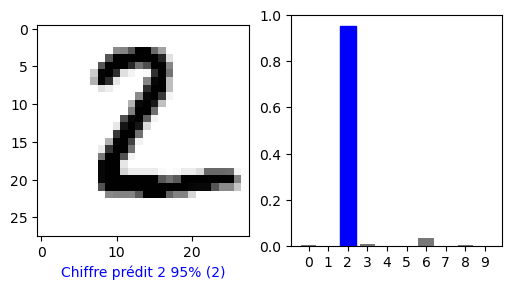

In [32]:
    ### SOLUTION ###
i = 1
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_prediction_image(y_proba[i], y_test[i], X_test[i])
plt.subplot(1,2,2)
plot_prediction_bar_chart(y_proba[i], y_test[i], X_test[i])
plt.show()

## Affichons les 20 premiers chiffres et visualisons les prédictions


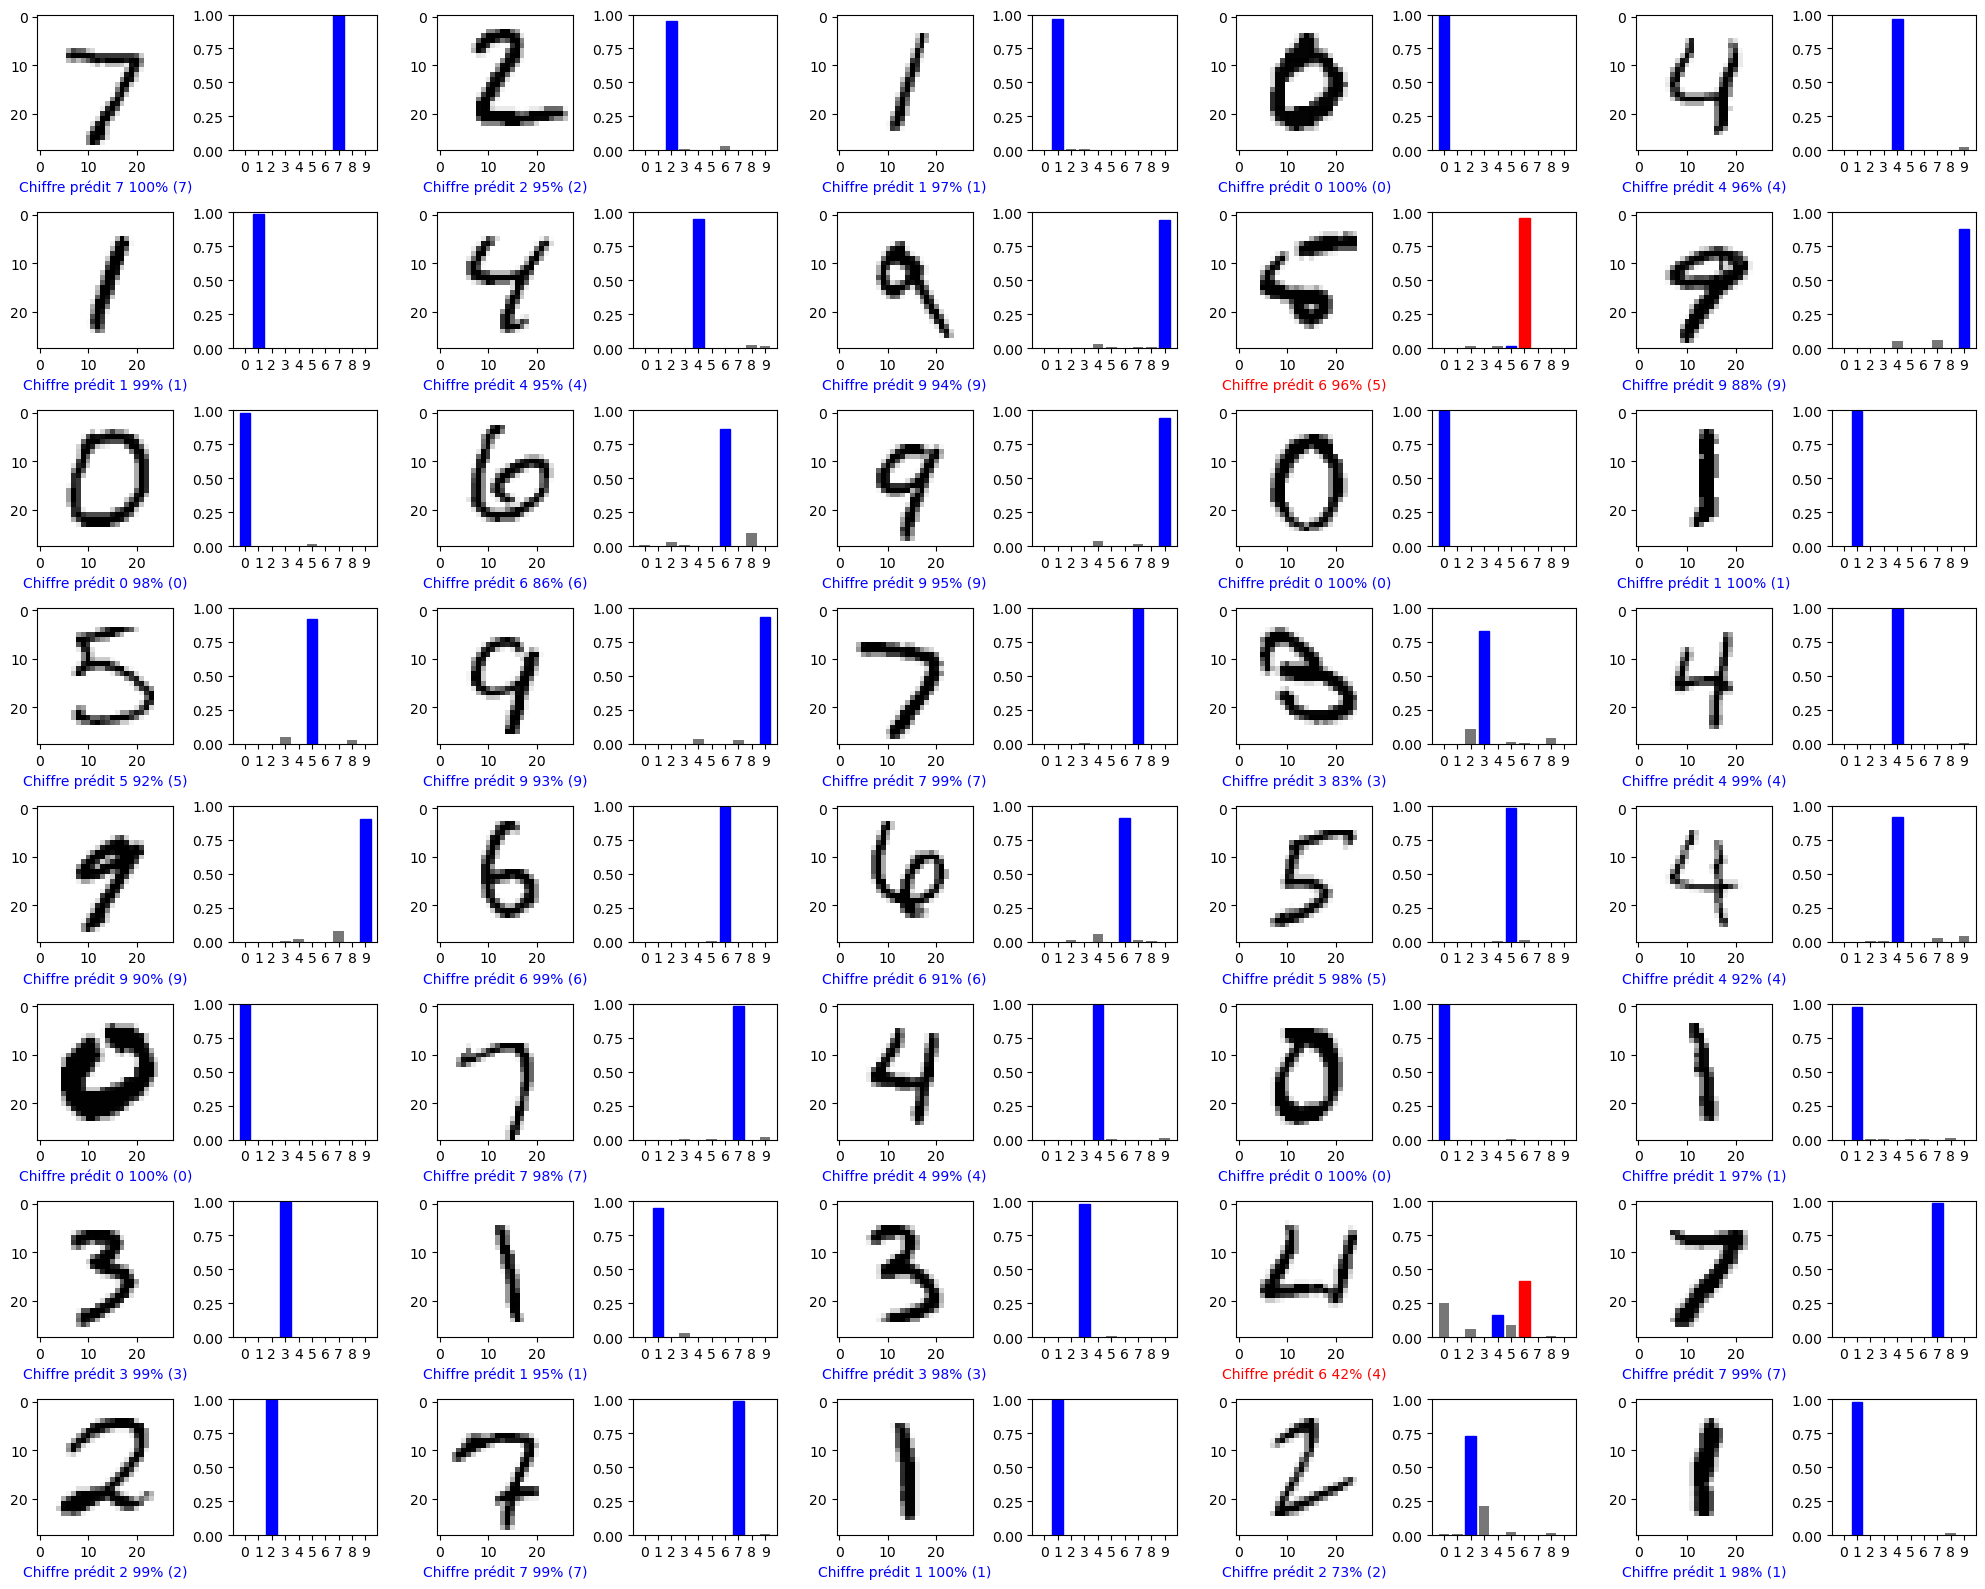

In [33]:
### SOLUTION ###
num_rows = 8
num_cols = 5
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for row in range(num_rows):
    for col in range(num_cols):
        index = num_cols * row + col
        plt.subplot(num_rows, 2*num_cols, 2*index+1)
        plot_prediction_image(y_proba[index], y_test[index], X_test[index])
        plt.subplot(num_rows, 2*num_cols, 2*index+2)
        plot_prediction_bar_chart(y_proba[index], y_test[index], X_test[index])
plt.tight_layout()
plt.show()

